## Matrix Factorization Based reco models

based on - https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

### Read Movielens dataset and create Train and test datasets

In [8]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [9]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [12]:
print(str(n_users) + ' users')
print(str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

943 users
1682 items
Sparsity: 6.30%


### Create Train - Test Split dataset

In [18]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]        
    return train, test

In [19]:
train, test = train_test_split(ratings)

In [20]:
print(train.shape)
print(test.shape)

(943, 1682)
(943, 1682)


### The ALS model can be represented using an equation
<img src="./images/Loss_function.png">

### The partial Derivative with Respect to User can be defined as below
<img src="./images/ALS_User_derivative.png"> and
<img src="./images/ALS_Simplified_equation.png">
 

### Similarly the partial Derivative with respect to Item can be represented as 
<img src="./images/ALS_item_derivative.png">

### Define a class for the above mathematical functions

In [54]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

## Calculate MSE 

In [55]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

## Call the Matrix Factorization class with a value of K

In [56]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [57]:
print(MF_ALS.train_mse)
print(MF_ALS.test_mse)

[5.38451697493879, 4.203044912238525, 3.9691310529713575, 3.935126952748242, 3.9243481394184636, 3.923320036466439, 3.9234425896108696]
[9.730004628298829, 8.594608192347616, 8.478064462465351, 8.470874469150763, 8.474548741369269, 8.47192490470504, 8.467190494064454]


In [58]:
print(MF_ALS.user_vecs.shape)
print(MF_ALS.item_vecs.shape)

(943, 40)
(1682, 40)


### Plot the Iteration Array with Train and Test MSE

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

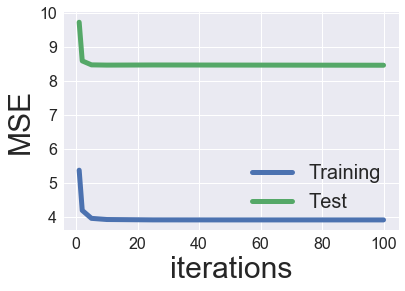

In [60]:
plot_learning_curve(iter_array, MF_ALS)

### Adding Regularization to the mix

In [61]:
train.shape

(943, 1682)

In [62]:
MF_ALS_reg = ExplicitMF(train, n_factors=40, \
                    user_reg=30., item_reg=30.)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS_reg.calculate_learning_curve(iter_array, test)

In [63]:
print(MF_ALS_reg.train_mse)
print(MF_ALS_reg.test_mse)

[9.872364051159025, 5.892602354643757, 4.9971113846051205, 4.865702836389762, 4.82059834918199, 4.816358822054352, 4.816088046751606]
[12.037445499707005, 9.096079578938925, 8.883290608388247, 8.802276453929727, 8.773494203376382, 8.769752972519383, 8.767822407823715]


In [64]:
print(MF_ALS_reg.ratings)
print(" ")
print(MF_ALS_reg.n_items)
print(" ")
print(MF_ALS_reg.n_users)

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
 
1682
 
943


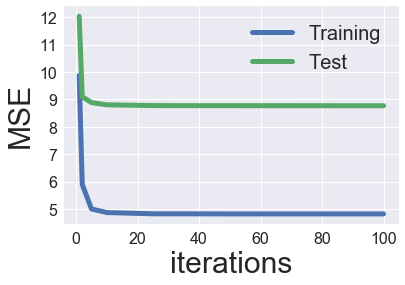

In [65]:
plot_learning_curve(iter_array, MF_ALS_reg)

## Instead of using numpy linalg solve use SGD for optimizing the loss function

### Usage of Surprise package for SVD, SVD++, NMF etc 

In [ ]:
!surprise -algo SVDpp -params "{'n_epochs': 5, 'verbose': True}" -load-builtin ml-100k -n-folds 3

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3


### Using Pyspark to train and predict an ALS model

In [ ]:
# !pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').getOrCreate()

In [ ]:
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.recommendation import ALS
# from pyspark.sql import Row

# lines = spark.read.text("sample_reco_file.txt").rdd
# parts = lines.map(lambda row: row.value.split("::"))
# ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
#                                      rating=float(p[2]), timestamp=long(p[3])))
# ratings = spark.createDataFrame(ratingsRDD)
# (training, test) = ratings.randomSplit([0.8, 0.2])

# # Build the recommendation model using ALS on the training data
# # Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
# als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
#           coldStartStrategy="drop")
# model = als.fit(training)

# # Evaluate the model by computing the RMSE on the test data
# predictions = model.transform(test)
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
#                                 predictionCol="prediction")
# rmse = evaluator.evaluate(predictions)
# print("Root-mean-square error = " + str(rmse))

# # Generate top 10 movie recommendations for each user
# userRecs = model.recommendForAllUsers(10)
# # Generate top 10 user recommendations for each movie
# movieRecs = model.recommendForAllItems(10)